# Exercise #5

This notebook is created by **Chinchuthakun Worameth** as a part of **Sparse Signal Processing and Optimization (ART.T465)** at Tokyo Institute of Technology taught in Fall semester 2021 by Prof. Ono Shunsuke. It contains
- Implementation of image restoration algorithm based on Primal-Dual Proximal Splitting Method (PDS)
- Discussion on its performance in different conditions
Symbol **[x]** indicates that a section or subsection corresponds to a question in the lecture slide.

## 1. Primal-Dual Proximal Splitting Method (PDS)

[Primal-Dual Proximal Splitting Method]() is applicable to non-differentiable convex optimization problems in the form
$$
\min_{x} f(x) + g(x) + h(Ax)
$$
where $f$ is a differetial convex function with a $\beta$-Lipschitz continuous gradient, $g$ is convex and proximable, andd $A$ is **any** matrix.

Given initial solutions $x^{(0)}$, $y^{(0)}$ and stepsizes $\gamma_1$, $\gamma_2$ where $\gamma_1 \Big( \frac{\beta}{2} + \gamma_2 \sigma=1(A)^2\Big) < 1$, the update rules are
$$
x^{(n+1)} = \text{prox}_{\gamma_1 g}(x^{(n)} - \gamma_1(\nabla f(x^{(n)}) + A^T y^{(n)}))
$$
$$
y^{(n+1)} = \text{prox}_{\gamma_2 h^*}(x^{(n)} - \gamma_2A(2x^{(n+1)} - x^{(n)}))
$$
where $h^*$ is the **convex conjugate of $h$**, i.e. $\text{prox}_{\gamma h^*}(x) = x - \gamma \text{prox}_{\frac{1}{\gamma}h}(x)$

## 2. Application in Image Restoration

### 2.1 Definition

Consider an observation model
$$
v = \Phi u_t + n
$$
where $v$, $\Phi$, $u_t$, and $n$ are an observed image, a matrixd representing an observation process, a **sparse** original image, and noise.

We can frame it as an optimization problem by introducing a **data-fidelity term** (squared error) and a **total variation term** (sparsity of local differences) constrained on an $N$-dimensional space as follows:
$$
\min_u \frac{1}{2}\Vert \Phi u - v\Vert^2 + \lambda \Vert Du \Vert_1 \text{ s.t.} u \in [0,1]^N
$$
where $D$ is the (horizontal and vertical) difference operator

### 2.2 Applying PDS

Similar to RPCA, we represent the constraint by an appropriate indicator function $i_{[0,1]^N}(u)$. By using variable-splittin g form, we can associate the squared error term with $f(x)$, total variation with $h(x)$, and the indicator function with $g(x)$, transforming the update rules into

$$
u^{(n+1)} = P_{[0,1]^N}(u^{(n)}-\gamma_1 \big(\Phi^T(\Phi u^{(n)}-v) + D^T y^{(n)}) \big)
$$
$$
\tilde{y}^{(n+1)} =y^{(n)} + \gamma_2(2u^{(n+1)} - u^{(n)})
$$
$$
y^{(n+1)} = \tilde{y}^{(n+1)} - \gamma_2 \text{prox}_{\frac{1}{\gamma_2}\Vert \cdot \Vert_1} \Big( \frac{1}{\gamma_2} \tilde{y}^{(n+1)}\Big)
$$

## 3. Implementation [Q1]

Again, we import necessary libraries and the self-implemented proximal operator from the previous assignment.

In [1]:
%%capture
! pip install ipynb
! pip install import-ipynb

In [2]:
%%capture
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import ipynb
import import_ipynb
from Lec2_Prox import proximalOperator

Next, we define two classes
- ```Transformer```: generate an observation image $v$ by downsampling the original image
- ```Restorer```: reconstruct the original imgae by using PDS

Note that this is the Python equivalent to the MATLAB code provided in the assignment.

In [3]:
class Transformer:
    def __init__(self, dsrate = 0.5, sigma = 10/255.):
        self.dsrate = dsrate # downsampling (decimation) rate
        self.sigma = sigma # noise standard deviation
    
    @staticmethod
    # observation process (Phi)
    def Phi(z, I, K):
        y = np.copy(z).flatten('F')
        return y[I[:K]].conj().T
    
    # tranpose of observation process (Phi transpose)
    def Phit(z, I, K, shape):
        y = np.zeros(I.shape[0])
        y[I[:K]] = z
        return np.reshape(y,shape,order='F')

    def transform(self, img):
        K = round(self.dsrate * img.shape[0] * img.shape[1]) # decimation rate
        I = np.random.permutation(img.shape[0]*img.shape[1])
        v = Transformer.Phi(img,I,K) + self.sigma*np.random.randn(K) # observation (decimation + noise)
        return v, I, K


In [4]:
class Restorer:
    def __init__(self, ld = 0.01, beta = 1, opDtD = 8, gamma1 = 0.8, iteration = 5000, tol = 1e-5, val_interval = 100):
        self.ld = ld # regularization parameter
        self.beta = beta # Lipschitz constant
        self.opDtD = opDtD # operator norm of DtD
        # stepsize of PDS
        self.gamma1 = gamma1
        self.gamma2 = 0.99/(self.gamma1 * self.opDtD) - self.beta / (2 * self.opDtD)
        self.iteration = iteration # number of iterations
        self.tol = tol # stopping criterion
        self.val_interval = val_interval

    @staticmethod
    #difference operator
    def D(z):
        return np.dstack([np.roll(z,-1,axis=0) - z, np.roll(z,-1,axis=1) - z])

    #transpose of difference operator
    def Dt(z):
        a = (-z[0,:,0] + z[-1,:,0]).reshape(1,-1)
        b = -z[1:,:,0] + z[0:-1,:,0]
        c = (-z[:,0,1] + z[:,-1,1]).reshape(-1,1)
        d = -z[:,1:,1] + z[:,0:-1,1]
        temp1 = np.vstack([a,b])
        temp2 = np.hstack([c,d])
        return temp1 + temp2

    def restore(self, v, I, K, shape, verbose = True):
        u = Transformer.Phit(v,I,K,shape)
        u0 = u.copy()
        y = Restorer.D(u)
        prox_box = proximalOperator(dict(name = "box", a = 0., b = 1.))
        prox_l1 = proximalOperator(dict(name = "l1", gamma = self.ld / self.gamma2))
        current_PSNR = 1e9
        for i in range(self.iteration):
            # early stopping if the difference between PSNR of current image and (val_interval previous steps) image is less than tol
            if i > 0 and i % self.val_interval == 0:
                PSNR = Restorer.PSNR(u,u0)
                if verbose: print("iteration {}: {}".format(i, abs(current_PSNR - PSNR)))
                if abs(current_PSNR - PSNR) < self.tol:
                    print("Early stopping at iteration ", i)
                    break
                current_PSNR = PSNR
            # generate next image
            u_prev = np.copy(u)
            u = prox_box.calculate(u - self.gamma1*(Transformer.Phit(Transformer.Phi(u,I,K) - v,I,K,shape) + Restorer.Dt(y)))
            y_bar = y + self.ld * Restorer.D(2*u - u_prev)
            y = y_bar - self.ld * prox_l1.calculate(y_bar / self.gamma2)
        return u
    
    @staticmethod
    def PSNR(img, ref, peak_val = 1.):
        mse = ((img - ref)**2).mean(axis=None)
        return 10*np.log10(peak_val**2 / mse)

    def compare(img, corrupted_img, restored_img, PSNR = True, label = ["Original image", "Corrupted image", "Reconstructed Image"]):
        if PSNR:
            print("PNSR of corrupted image = ", Restorer.PSNR(corrupted_img,img))
            print("PNSR of restored image = ", Restorer.PSNR(restored_img,img))
        plt.rcParams["figure.figsize"] = (30,20)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img, cmap = 'gray')
        ax1.set_title(label[0])
        ax2.imshow(corrupted_img, cmap = 'gray')
        ax2.set_title(label[1])
        ax3.imshow(restored_img, cmap = 'gray')
        ax3.set_title(label[2])
        

Then, we test the algorithm on a real image ```culicoidae.png``` as shown below.

In [5]:
image = Image.open("culicoidae.png")
img = np.array(image)/255.
print(img.shape)

(256, 256)


iteration 100: 999999990.1111459
iteration 200: 0.10550448181003347
iteration 300: 0.0004696311116916263
iteration 400: 0.000268573204673217
iteration 500: 9.581772912525821e-05
iteration 600: 6.381738389471536e-05
iteration 700: 2.5418623351924907e-05
iteration 800: 1.6758684218132203e-07
Early stopping at iteration  800
PNSR of corrupted image =  9.745311162371369
PNSR of restored image =  25.980788125201183


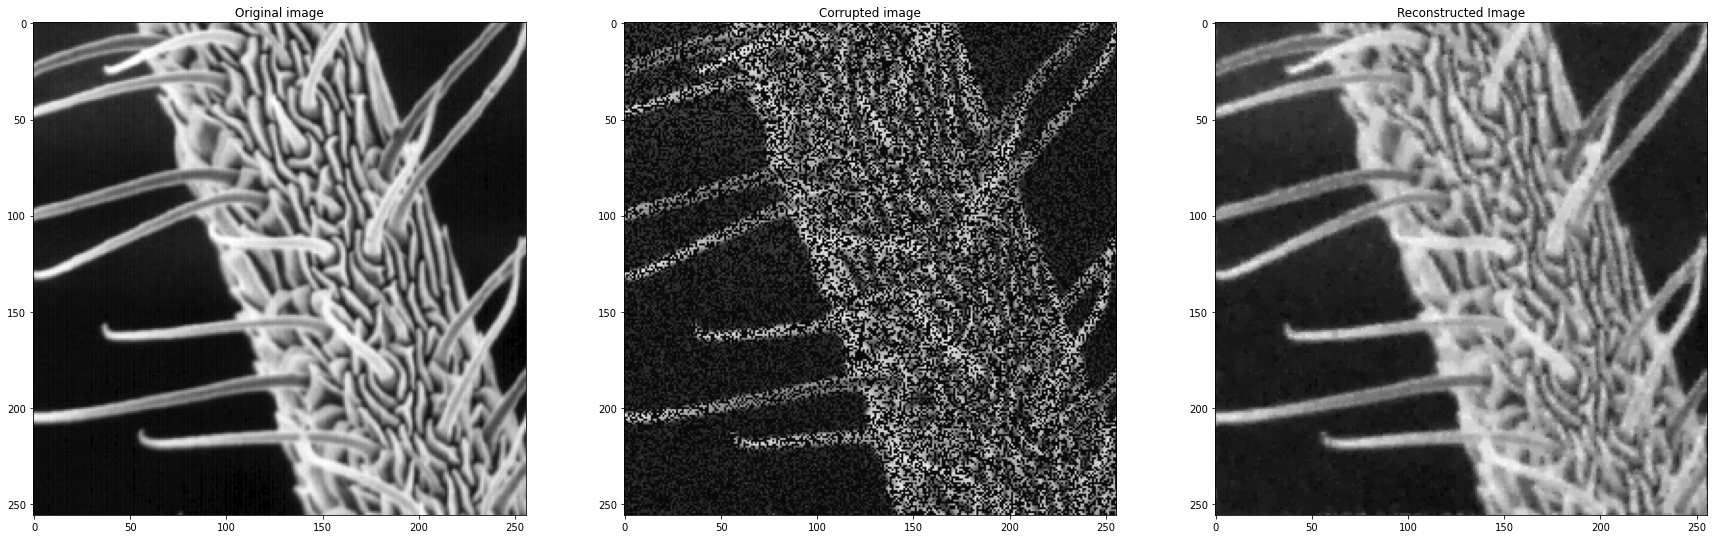

In [6]:
corrupted_img, I, K = Transformer().transform(img)
restored_img = Restorer().restore(corrupted_img, I, K, img.shape)
Restorer.compare(img,Transformer.Phit(corrupted_img,I,K,img.shape),restored_img)

## 4. Performance under different conditions [Q2]

### 4.1 Weight of L1 norm

In this section, we consider how sparse regularization (total variation) affects the performance of PDS-based image restoration. Specifically, we adjust the weight of L1 norm ```lamda``` to slightly lower and higher and discuss the results.

Early stopping at iteration  800
Early stopping at iteration  1000
Early stopping at iteration  1500


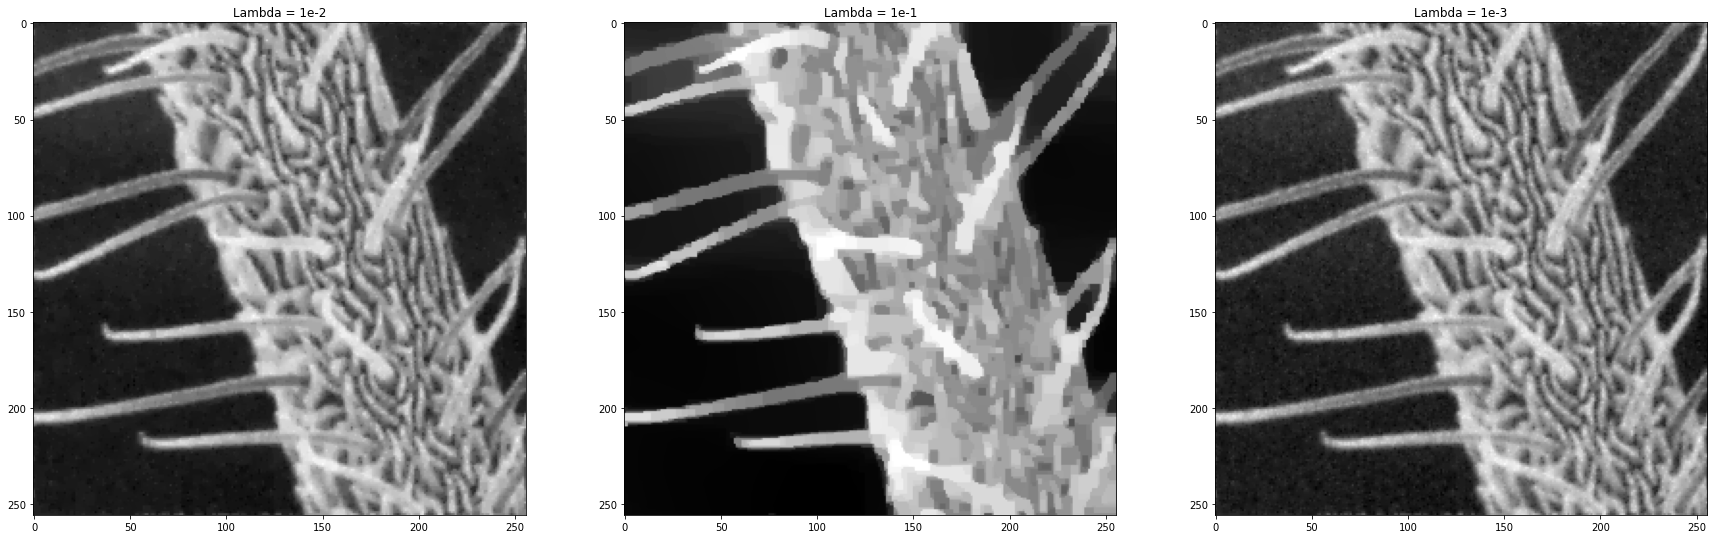

In [7]:
restored_img = Restorer().restore(corrupted_img, I, K, img.shape, verbose = False)
restored_img_highLD = Restorer(ld = 0.1).restore(corrupted_img, I, K, img.shape, verbose = False)
restored_img_lowLD = Restorer(ld = 1e-3).restore(corrupted_img, I, K, img.shape, verbose = False)
Restorer.compare(restored_img,restored_img_highLD,restored_img_lowLD, PSNR = False, label = ["Lambda = 1e-2", "Lambda = 1e-1", "Lambda = 1e-3"])

From the results above, we can draw the following conclusions:
- With an exceedingly low sparse regularization, the sparsity in local difference declines. As a result, more noise are introduced into the right image, especially in the background (black area).
- On the other hand, a high sparse regularization encorages higher sparsity in local difference. We can easily observe that there is less local difference on the surface of the interested object in the middle image.
- Hence, the regularization parameter must be carefully chosen to balance between these two extreme scenarios.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ceb3b963-7d26-4b9f-840e-3ecd7c45577b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>